# Generation guide

1. **Pipeline from template** — use a ready text-to-image pipeline and run generation.
2. **Full graph with each node added separately** — build a graph from scratch by adding each node one by one (Conditioner, Denoise loop, Codec, then connect).

---
## 1. Pipeline from template

Get the pipeline from a text-to-image template and run generation. No graph building — just pipeline and generate.

In [ ]:
from pathlib import Path
from yggdrasil.pipeline import InferencePipeline

pipe = InferencePipeline.from_template("sdxl_txt2img", device="cuda")

output = pipe(
    prompt="a red vintage bicycle leaning against a yellow wall, sunny day, photorealistic",
    num_steps=30,
    seed=42,
    guidance_scale=7.5,
    width=1024,
    height=1024,
)

img = output.images[0] if output.images else None
img

---
## 2. Full graph with each node added separately

Build a graph from scratch: create an empty graph, then **add each node one by one** — Conditioner, Denoise loop (with backbone, solver, etc. inside), Codec — then connect them and expose inputs/outputs.

### Как я хочу чтобы выглядела сборка полного графа TODO:

In [1]:
import gc
import torch
from pathlib import Path
from yggdrasil.core.graph.graph import ComputeGraph
from yggdrasil.pipeline import InferencePipeline

# Освобождение GPU при повторном запуске ячейки (re-run без перезапуска kernel)
for _name in ("pipe", "graph"):
    try:
        del globals()[_name]
    except KeyError:
        pass
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

pretrained = "stabilityai/stable-diffusion-xl-base-1.0"
device = "cuda" if torch.cuda.is_available() else "cpu"

graph = ComputeGraph(name="MyAwesomeGraph",)
graph.add_node("MyAwesomeConditioner", type="conditioner/clip_sdxl", pretrained=pretrained)
graph.add_node("MyAwesomeBackbone", type="backbone/unet2d_condition", pretrained=pretrained)
graph.add_node("MyAwesomeСodec", type="codec/autoencoder_kl", pretrained=pretrained)
graph.add_node("MyAwesomeSolver", type="solver/euler_discrete", pretrained=pretrained)
graph.add_node("MyAwesomeDepth", type="adapter/controlnet", pretrained="diffusers/controlnet-depth-sdxl-1.0", control_type="depth")
graph.add_node("MyAwesomeCanny", type="adapter/controlnet", pretrained="diffusers/controlnet-canny-sdxl-1.0", control_type="canny")
graph.add_node("MyAwesomeIPAdapter", type="adapter/ip_adapter", pretrained="openai/clip-vit-large-patch14")
graph.to(device)

/workspace/YggDrasil/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading weights: 100%|██████████| 517/517 [00:01<00:00, 324.17it/s, Materializing param=text_projection.weight]                                


Loading pipeline weights in parallel (one-time)...
  Loading denoise loop (UNet)...
  Loading VAE (codec)...


/workspace/YggDrasil/.venv/lib/python3.10/site-packages/huggingface_hub/utils/_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


  Loading IP-Adapter image encoder (CLIP vision)...


Loading weights: 100%|██████████| 392/392 [00:01<00:00, 334.17it/s, Materializing param=visual_projection.weight]                                


  Loading IP-Adapter...
  Loading user solver...
  Loading ControlNet...
  Loading ControlNet...


<ComputeGraph 'MyAwesomeGraph' nodes=5 edges=6 inputs=['prompt', 'negative_prompt', 'height', 'width', 'latents', 'timesteps', 'ip_image', 'control_image_MyAwesomeDepth', 'control_image_MyAwesomeCanny'](9 targets) outputs=['latents', 'decoded']>

Sampling:  50%|█████     | 15/30 [00:05<00:05,  2.71it/s]

Sampling: 100%|██████████| 30/30 [00:11<00:00,  2.72it/s]


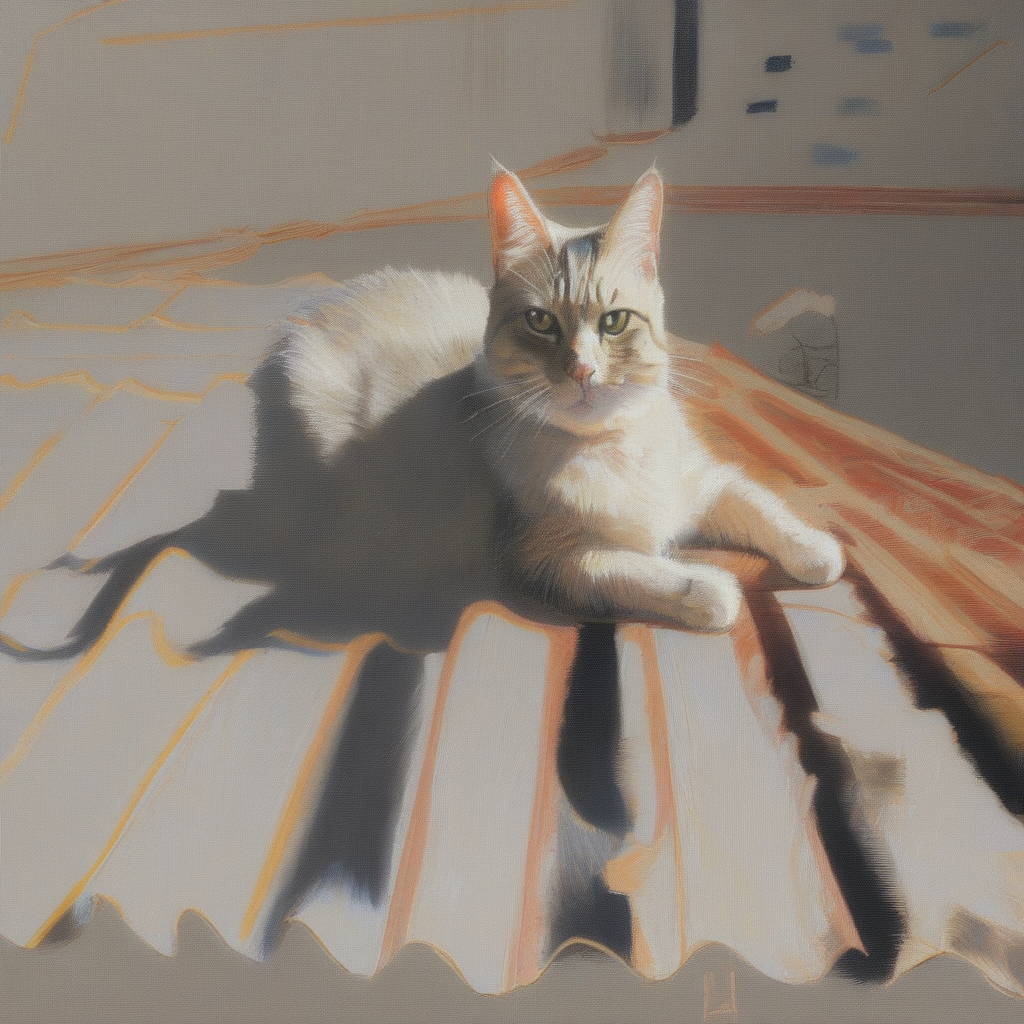

In [4]:
pipe = InferencePipeline.from_graph(graph, device=device)
output = pipe(
    prompt="a cat, sunny day, photorealistic",
    num_steps=30,
    seed=42,
    guidance_scale=7.5,
    width=1024,
    height=1024,
    control_image={
        "depth": "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/multicontrolnet_depth.png",
        "canny": "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/canny-cat.png",
    },
    controlnet_scale={
        "depth": 0.7,
        "canny": 0.3,
    },
    # ip_image=[
    #     "https://media.cnn.com/api/v1/images/stellar/prod/gettyimages-142832910.jpg?c=16x9&q=h_833,w_1480,c_fill",
    #     "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxISEhUQEhIVFRAVEBUVFRUPFRAVDxUPFRUWFhUVFRUYHSggGBolGxUVITEhJSkrLi4uFx8zODMtNygtLysBCgoKDg0OFw8QFS0dHR0tLS0rLS0rLS0tLS0tKy0rLSstKystKy0rKy0rLS0tLSstLS0tKy0tLS0rLS0tLS0tK//AABEIAKgBLAMBIgACEQEDEQH/xAAcAAACAgMBAQAAAAAAAAAAAAAEBQIDAAEGBwj/xABBEAACAQIEAwYDBQcCBAcAAAABAgADEQQSITEFQVEGEyJhcYEykaEHQrHB8BQjUmKC0fFy4RVTwtIzQ2NzkqKy/8QAGAEAAwEBAAAAAAAAAAAAAAAAAAECAwT/xAAdEQEBAQEBAQEBAQEAAAAAAAAAAQIRMSESQQMy/9oADAMBAAIRAxEAPwA6qYg4y3hMc1qmk53jFTQyf6d8c4ZICZLFWaM42qywLNostVIlKwssVJMJLUSAH4OlpGuGwsq4bQvH9DDzG+tYGpUYD2o4uMHhzVtdyQqKebn8gAT7ToFw84D7Wl8eEQ7E1WI9O7AP1MIKWcJ7dYpGvWRalPchRlcD+Uz0vhGMpYmmK1JsyH/5A81Ycj5TxqsugamQVttzEZ9nO0zYOoHtekdKwJNyL7qLfEt/L6yp9Tfj180JtMNDcIyVEWohDI6hlI2KnUGELQi4Zf8As0z9mjPupruo+DpW2FmxhozNKYKUXB0tOGkTh417qKuO8Zw+EXNXcAn4UGtVz/Kg1MODqtsNKamE8pxuN+005rJhstO41qHxlb9BoD856DhGFSmlQbOisPRhcRWCUpbCyh8NHz4eUvh4vyfSFsLKKmD8p0Bw8pfDypkukIwI6SD4KPjQlbUZNyfXPtgpTUwU6B6EpejHMl1zNfBxbisIZ11WhF2Kw0qFY88x65TAWedDx3CcxObYTSMNTlTvN3kUlgWMnq1arpOe4nUvGlZ4lxpkZ9a6oACXosqQQqksupiymkvCTdJJbliWrVZciTEWFUqcAe8Io6TocPSivhC6R/QSYf1qxKM8y+2umFbCP/LXW3P/AMs3nrKJPHftwxF8VQpX0XD57DcFnYE+4UfKVE68JezOAVUNRyDcXAyuBludyeV1ME4tTU3Kq4vqNLLY6kg6C2g0tCF7S4dEsmH8YUWapkDFRoALcvKKcT2hdySVU35NmOvqeU0kZ2uy+zXtqMOf2SoCaBYtTuQWp5tXW40I+9y3baen4btZgnXOKygdDe+k+c83duKq8irWB2BJ2HTlrsfIxgnEQrEgC4bxZSwBt4dFJOpH4w5C/Vj6MocVoOMy1VI9dpcuJpnZ1+YngXCuKi9y5Aux5XLW3P8ALtfrGFfioCs3eq9vEp8Q1ta1wfO8f5H7e3O6gXuLdbi0CxPGsNSuKlempUXOZl0G88D4hx+q3hWo2UDTMxIFuflE7Y9yTc+NubXOUcz+ftF+R+3rvan7T6aXo4JTUrHTOwORb8wu7HyNpxLYKu57+q96rXLNVGZyBuRyt5aW6GD8B4cSPAyl9STfX1YjxWPpy3nVU+F1Eo1WA/fKFci1lIR1YlbCxuFOvOTV5++ufxPDFrtTpByC7qoyqXc3P3VHPzJC8yRPcsNhBTRaa/CiKovvZRYfhPNvsp4ScRXfHutqdC9OiNh3rjxsByyqQB/r8p6sUk5nxp/pZdfAZSVtThbpKXSXIjoN1lWSGPTleWPiehWpSpqUPIlTrEZbUpwZ0jKqsDqCIwFRYBiVjOqIvxMYcxxaje84zF0bMZ3vENZyuNoeKEZ7hVTpS4UoUlGWilH1PHWVjFWKjKoYuxAiyegtNYZRSU0Uh9JJdPK2jTl3dSyikJFOSoIlOF0qc2tOEIkDOeGbCP8ADGIOH6CO8M0y1Gs8MknjH26UlGJouvxvQytbeyOxHzzfSexo0+dvtG4u+Jxjs3woxRP9INo8eo345m5I9NBfpv8AnJ0nUWuL638pAsT8pEKZqyFV8UahN9OfhGlrai1/IH2Mi99Wte4p9dypufmplap97p+PnLs2mUdR62Gf/ugOspN6jz5D9fnJZ7Aj287af3m+70032HQn87TMLlzEMCRrbLuG/PWNAfORpc6fgf0JlFCT4d7XJOw6k+ULq0LakW1ytcfDpe/ro2nkZt6Nh4dF0Lk9dbD26DmfKJTKePZWCoLi/IEMzeQUiw02E7bsx2rNNXoYhiQ1NirUySyW33567C+3XQ8L+0DYAAHc7ORzuenkNPWW4PBuatMU1LM9RQo6sWAy2isOX6+ifsvpAcOpHcM9ZgSMpYGq9mIubX/C206krBOBcPGHw9HDg37ukqk9WA8R+d4cYRd9UMkodYS8GcxhQ8GqS+q0CrVIyYXlT1pRVrRdXxUmnBtavF2IxQEDr4vzirF4zzkn0yq42BV69+cVtipBqpjLqWMqiJa631h9U3grrBNChJYFkskmBAjmpAK0NqGA1I8p0lh1jKikCwgjWgkdXldRSEqkyjThC04lqVSXqkkqS5UgBmEXQRphzFtDQCGU6torB0wq1MqM3RSfkJ83cdGao7W1Z2JNiNzpPd+0mKthau1+7IF9OU8Or0jvoWJvlF9vPSVmMv8AXX2FQoG1tN7f4hVLh1S2yf1E/npI4mkdyNdyF0Ci/kLTpvsxWm+NTD1wGpOGI7xQSStmUC+18p25XHOGr+Z1MvXLvhGU2BF+lnJI6aDeDGqc2vIZQLWtby9dT53n0fxThWGqV1wpwVM03w9R2qImXLZqaBc68zmY7/cni3b3sn+xYhkptmpFQyZiMyqbjKetiN/SZ5/1mrwyOihY3+6AbE7X0t+XylNDTMRyOnrL8KwCG/pc+g5e0v4Phs9yb2Av8zNSV4u5pgX1FnN97sBe/X/M1hwCmpFhb4je2a+tuZ059RDOH9n8Riqvd0abMxvoNAFB3JOgG2873C/ZRiMjFa1HvFFilNqhObKGCE2texB25iTdSem83qUVO2X2Iv73PpC+AVGpYilV2NOorAMbDQ62HOGY3BrSdqNaoodNwN7kAi4GnP2hGAww8L33J53Fhtp0+cpPX0VhsSGUN1UH5iWNVE5Gnxbu1C9FGh9JCp2g6zPro+OpqYgQKrihOYrcdB5wN+Lkw6Pjpq+LEX1sTE3/ABEymrjbxdHwdicYBFVfGiUVXJg7pGm1HEYvpAHJMMalImlGmgskllhQpTDSgQQrImnDDTkGWBwCySOSFlJArAVc7wR2m6lSDZ9ZWYztM8FHOHEUYIR1hxCtcjqCwkLKqEIElo0qywLNKJaBAMDaTXfyqqbQGtWtGjV4A7a8Ty0Ql/iO2lrDrPMq9c7+fLb58p1Xbuub0wL/AAnb85yuy7G/r/vLnjDX2hauuu4/CRo1nRldLqysGVlvmUjUS0sDvf3H95W9P5eVzFTjt+G/aviKa/vKKPUygZwcrEDWzGxNrkm05ztD2kqY2oatW1zoqjkLdbXOv66oqifr/EhSGsiYzL2RQ3vhlt5xzwCuqhj5bHp0iJFJseV4+w2CyUmfmd9rAm9tuWk04iV6J2D7RYbCZqdbLTarZkdz4HU3soY7c9PMR7iO3GBwYrVlrK7VKhqd3T1c1O7RABrt4B5T5/xuJd7ZjewCjyUbD5SqnT11/wB5hf8APt71p0TjsW1es9Zz4ndmPlmJNh5C87Xs3RACg2IbLa+oF9De361nJ4DBliMo578x56Tu+G0CSif8uxNzcknY+mk18Keuj44cpsDqANttogqYk9Y67QVLnfkNvSc05kxWr9XrWMIpVIAkMorFSgwNNEyKibIktK0ZlpgmwZSKiVmiksMrd4JtaIkGMi7yh3jLqxjKyZAtIM0D/STSoibLyBaA/QSo0pTeY5kaB1l5Z309wAjugIlwEd0DFW+fB9GEAQegYWoktG1EtUSCy5YGExKxNijrHuJER4veNltyfbmndEe+xIIJP4TlKJv0+R/Gd32qoh8Ob3uGFrW395wKlUOgu43zE5B62sSfKNlxbUpe2nIEi/rf6wXKRfpDKGKZrkC9tybCmPUsbD5iHrRuMxYC25WyLryzML/SMcIVsTa2ntNvTA9Ooh+IwbKbkLb+Zyb9Trrb2lJpnZilhpZTAC/+Hs6DuVzoo1ZSL5ra6biN1TLgD3l0YVwqq9w7hlN8o52IHzi3hXEEoCwJsWDWF/EF8Vj7i3vAyR3jVW1uS1hrqT9TDp8kU9yAdTYbHfYekuw9FSb3sv8AVv7Eyl63eMBcXJ6Eb7R1j8CKQVdLlQSb7t7/AAkQDeD4hTQAIgzX1Yi/PlbadC9awV1Nwzjwm9wNOY/Wk5vA1aSXZhccjrlvcW22OloVgKrPUBOwOmaxIHtuPMRHHe8SoFkRtNVEQ1sMRynUcObvMNdhdkNj6cjAmRToCPQxcXYR06UMo04YcJ0H9pvu7TOnM8U5ZW5lzwd45BaiXmg0haSAlM6neV1JaBK6ogmhnaUsZOpKmghrNIsZoyLNAdQYzV5omZmjHQxE1SEmTIIdZWRfTrAtG9F4mwMb0Yq6M+GmGMNUwHCiGiS0ixTLkMGUy9DA1eIiTGbxziDE+Kgz2T9oLGjk1zMdAvxTz44JUPjOZhqUHwqOrm/5jl8W06ztJibVMuYqMupA1t0v+XOcti6DO/dpovxXJFgo3dz5D8bDeXz4xl+q1xVyMovl2Y2001CDQL1JsBbcdTqWIC/vKh0G177/AMi/d9dz/KBBmemq3H/hqct/vVHGtlHQXBJ8+tiFlSo1VxfmbAcgP8D6RNK6jDVu9GYqCl7gaXAGnvr+PrBK3Ecvw079M5016jS+sWtiigAQkC9hbouh+ZY+635wteLo1lqrew1K9fKBcSpvTIPe0VapyZWqKwvzsG1+UKwfAGr/AAeE3Ny/wixA0Yb9fSWYXiWFzhvEDba5sTtY9Bt9Zs9prIRTUKLFxfcbXHzv62iPhrheG0sICzv3tYaKmlgx1tci9zrbqSIm4pV7wCrTNwEuUtcZR95Qd13uu6m/sJicWzfvLm5UMLfFdStW481FcnyyXkszBwUsveklCPhp4rZlF9lY3t69LxjgXDYnW9M5X/hYju2HMXP4N89o0w1cXuqlRcZgNHRhvoeX12iqvTV1NemtiNKqDZGP3gP4Tr6fOWcNr6hCfIE7oeWvNeRB5HS0EvWOwjd4rpcMCtvXTS8QcZc0qpW9mB2G1ow7AtlqGwspOltvMX8ttbekL7d8NRyX+FwdxuY81Wp3Jbw3jemVtT9I5urC6m888BZTYk+4tePuE8RK2B2j1mVGd3ynVQQWoYxW1RbiAOmszXVFpNRJhJYqwShaVVpc+kDrPBFD1TA3qyyvUi6rUlSMrRQq3mM0DSpL01hwdTtJBJNEl2WJUgB1lSDWWsZWu8rKr6b4COqAibAR3QirfPhjh4UIJQhayWkbEtBlYm7wNDEGKa+8Y12iutBntwHH6xqVSOhNydgBzPpA6wUgJcimfE38bhdS7dALEgfK5uZvjxs7cvFcgdRtf0gBrnIx3LELre+UeJvrkmlYQHia2ZrgWGyqNlTkPz8ySZKi2VWf7x8K+XNm9tLesxqYC5m5jwKNz/Mei/ifciusfhHRR828R/ED2ktYxm0X/T9czSuTZbAdSCfa5HtsZunRJJFtcpYeigk/QH3tAKzJpUtpyh9PhmUCo7KFuOZzagsmnnaEV8HRKXQ2DKrXZh4STbUb2BZRfoddQIgppG5RTzBXTq2Hpp+YlWCfOjUidwGXyYAC/wAsuvQNIo/jpn/1Mx20Ge1vkn4wfBvlZWOoB8Q6odGHuCR7wMfRxZSp39rZrrVW2mb7wI6G2a3UEcoVXw4XxpqhOnPKf4PPQgg8wQesGqUrMcxFmJR25CqhtnI+Ted26w3hrtY03FgDlbysdDfqp+hPSBV23Yd8rLyJ+WkcdvGaxYbixtpqLRD2aYpVUNbQWGlr73t/aOO3z/ulezWK626jnHD1/wAuI79awysCGA5HW83hAwNhf+reDoVcAg+Ly5jrLGq2Oov7S2Lr+C437pH1jLF0OYGk5DBYgAg2sfI6TtMDW7xct9ZOo0n2F80WluJpEGDgSEtPBK4hjQeqsE0mxMW1Y6xFOL6lG8uMbAiAwygDMWjCKSQpyLqay0CaWbzSGshYyypd5e5g99ZeRqG+AaOqDRBgjHNBoq2z4bUXhaNFlF4WjyWkFZpotKs00WgaNd4trtDK7RViH1gx3XCdo6NqrDXe46RPVNlTocx97gf9InTdsaJuHGxGs5ao3gHkzD2NiP8Aql1nlGmmYhevM8hzPsBNMpdiVBN2/H9fSV3/AF5R92ffuvGVvfxeLKAoAIBN9TfU8hZTvEtZwjs29ZrFrkoLZbk2DAADz0A6b9DHXHeBth89TIxdaSMuoKq+cC1tyNRf1PKO+E8XWio0IXKuZjbMFPnyvY7cgNbLoq7Rce7yqLgLdTT0a9izgLbpqrf/AG8olfOORxbGwWxsAGQkf8sN4GB5aNbpc7jZabE+HQX0BOg9/wA41xvEbPUB5MyoNCQQWs9/4tbe5iqgNR0GvsBc/QGBLQbMbH4UI98uX/8AR+sg1Kyg3BvfQEXA03G45zG0BF73Nr9QvP0J/CRDdYAaXzGxOlSmm/KogyBj/UrD0aGJVLBd76K3XMu1x6W91MAapYIUvYZhc76Nmtp/rjLAMWBsNSLtoLXXUN62v7nzgK7bs8oYKLbWuD9CPlOl7T4E1cFmXdCdPLzE53sq2qjqdCdr/ofWdzRbwGm2xBB9D0jVJ2PCsOxVrcr8jqD1BjHEtfUWb6H5yHa3h37NiSAWKsbgt+UER9NTr+XnKYeGuCq3sBf3/IzreD4mxE4ahUK2O/pOo4VUDJHVZv11GOS+vIiLmWF4GoGXKTqIPWEyp6UNKXEtYyiq8EBqywV6cIZpFzGihSs2sk0yByJZpl5ANMzRNZAtRIIdDHVSlpFWIXWPNGoNwTRvRaIsE0bUnjq8mVJ4XTeKkqwqnVkrg8PJZoKryYeBsxBijEtGVdtIpxJgx2VdoaeakD0NpxLr8Q9/6h/sTO+x65qR8tZw+OXWX/GeQMOwBVnBZ/GzKCWvoCwuF3zMR1sBAyfKTw9UowcWuDcZtr8j7byWhxi8c60mpjRmqLUa58SbFcw2BJtYX01vqTFQxJIck+PwZTzFm5dJtMWQRbUDMfFqWqMNXbr6eXW5gx/GBtGavLClhcn25yBH69YBJzr5DQen6195IiQBkgYAQAMi/wDuP+FOMeEk57gXIINtbkDcf7RYbZVv1b8v7RrwR7NfltbbfT2hCru+ziZSOuYb6GwPMdZ1WMq5CL7G1t9Pac72Zp3Ks1ydCCddjrf5iNuMV8zZQOelt9OY6iDSeOc+0TDgpnvqLHXaefpVvv05dJ6B22xYVFU2N121vPOKb2a42/KVGO/TjCqrKQDrOg4NVATKxII2nP4ZxuAAY84TWDeE6GMZdJg62WxJvpvCca4IzCL1tbLseRl2FPhKnW0mrs+A6taDNUvLK6wVomFSZ5Q9WaqNB3aCU2qyDVpRUeVZ7xnKNV5YDBaZloaJtDqskTYxNZkyTF7QwrRmjzJkujKxHhNOpMmRGvWrLFqzJkRo1qkBqreZMjRpUad1ZeonFcSoHUdCb+UyZKnjL+lh89TyPKVldf7zUyJcbIGmvLX1mXttMmRG0y/rlrrNu23pa/lMmQNDaSUzUyATAO8d8BILgEXF9h0G4t1m5kCr0HstiCbC2otY87f2MZmtndl/hbTW2vpymTINJ44Xt1xHM2S9iDppy5i85FN7dZkyUxvplhOSmO+EEXKn4hMmQOHK1CQLexhfCat2KkCZMhVxrG0wCYvqCZMkM9QFXEEYzJkqM7FTi8xaUyZASLUWWCbmRNI//9k="
    # ],
    # ip_adapter_scale=[
    #     0.7, 
    #     0.9
    # ],
)

img = output.images[0] if output.images else None
img

<!-- ---
## Conclusion & ControlNet notes

- **IP-Adapter:** Use `ip_adapter_scale=1.2`–`1.5` for strong resemblance to the reference image; `0.6`–`1.0` for subtler style.
- **ControlNet (Canny):** If you enable ControlNet and generation breaks or looks wrong:
  1. **Pass a control image:** When the graph has ControlNet, pass `control_image=...` (path, URL, or tensor). If you don’t, ControlNet returns zeros and has no effect.
  2. **Use an edge map for Canny:** `controlnet-canny-sdxl-1.0` expects a **Canny edge map** (black/white edges), not a normal photo. Passing a raw RGB photo often gives bad or broken results. Preprocess your image with a Canny detector (e.g. OpenCV `cv2.Canny`) or use a pipeline that feeds a preprocessor output into ControlNet.
  3. **Сила контроля:** Передайте `controlnet_scale=0.5`–`1.0` (по умолчанию 1.0) в `pipe(...)`. Для нескольких ControlNet можно задать силу по отдельности: **список** по порядку, например `controlnet_scale=[0.8, 0.5]`, или **словарь** по типу: `controlnet_scale={"canny": 0.8, "depth": 0.5}`.
- **Multiple ControlNets:** Add several with `graph.add_node(type="adapter/controlnet", pretrained="...canny...")` and `graph.add_node(type="adapter/controlnet", pretrained="...depth...")`. Pass `control_image` as a **list** (one image per ControlNet; order must match the graph: first item → first ControlNet) or a **dict** for any order: `control_image={"canny": url1, "depth": url2}` — keys are control types, so the order of keys does not matter.
- **CUDA out of memory:** При переносе на GPU пайплайн выставляет `PYTORCH_ALLOC_CONF=expandable_segments:True` и сбрасывает кэш после каждого блока. Если OOM остаётся: закройте другие процессы на GPU, уменьшите `width`/`height` или используйте один ControlNet. -->

### Генерация со сменой Solver

Можно заменить solver (Euler, PNDM, DDIM и т.д.) перед генерацией: получить внутренний граф `denoise_loop`, вызвать `replace_node("solver", new_solver)` и обновить `scale_input.set_solver(new_solver)`.

In [ ]:
from yggdrasil.core.block.builder import BlockBuilder
from yggdrasil.pipeline import InferencePipeline

# Загружаем пайплайн (как в разделе 1)
pipe = InferencePipeline.from_template("sdxl_txt2img", device="cuda")

# Собираем новый solver (например, PNDM вместо Euler)
new_solver = BlockBuilder.build({
    "type": "solver/pndm_diffusers",
    "num_train_timesteps": 1000,
    "beta_start": 0.00085,
    "beta_end": 0.012,
    "beta_schedule": "scaled_linear",
    "steps_offset": 1,
})

# Заменяем solver во внутреннем графе denoise_loop
inner = pipe.graph.nodes["denoise_loop"].graph
inner.replace_node("solver", new_solver)

# scale_input должен использовать тот же solver (для scale_model_input)
scale_block = inner.nodes.get("scale_input")
if scale_block is not None and hasattr(scale_block, "set_solver"):
    scale_block.set_solver(new_solver)

# Генерируем с новым solver'ом
output_pndm = pipe(
    prompt="a red vintage bicycle leaning against a yellow wall, sunny day, photorealistic",
    num_steps=30,
    seed=42,
    guidance_scale=7.5,
    width=1024,
    height=1024,
)

img_pndm = output_pndm.images[0] if output_pndm.images else None
img_pndm